In [97]:
## Step 1 - Import the Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import ta  # Technical Analysis library

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [87]:
## Step 2 – Reading our training data and getting our training data in shape
# Define the training time frame
start_date = "2004-01-01"
end_date = "2024-01-01"

def get_dow30_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].tolist()
    return tickers

def load_stock_data(ticker, start_date, end_date):
    ticker = ticker.replace('.', '-')
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def get_top_100_by_volume(sp500_tickers, start_date, end_date):
    volumes = []
    for ticker in sp500_tickers:
        try:
            data = load_stock_data(ticker, start_date, end_date)
            avg_volume = data['Volume'].mean()
            volumes.append((ticker, avg_volume))
        except Exception as e:
            print(f"Error loading data for {ticker}: {e}")
    
    volumes.sort(key=lambda x: x[1], reverse=True)
    top_100_tickers = [ticker for ticker, _ in volumes[:100]]
    return top_100_tickers

sp500_tickers = get_sp500_tickers()
top_100_tickers = get_top_100_by_volume(sp500_tickers, start_date, end_date)

def feature_engineering(data):
    data['macd'] = ta.trend.macd(data['Adj Close'])

    bollinger = ta.volatility.BollingerBands(data['Adj Close'])
    data['boll_ub'] = bollinger.bollinger_hband()
    data['boll_lb'] = bollinger.bollinger_lband()

    data['rsi_30'] = ta.momentum.RSIIndicator(data['Adj Close'], window=30).rsi()

    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Adj Close'], window=30)
    data['dx_30'] = adx.adx()

    data['close_30_sma'] = data['Adj Close'].rolling(window=30).mean()
    data['close_60_sma'] = data['Adj Close'].rolling(window=60).mean()
    data.dropna(inplace=True)
    return data

all_data = []
for ticker in top_100_tickers:
    try:
        data = load_stock_data(ticker, start_date, end_date)
        data = feature_engineering(data)
        data['Ticker'] = ticker
        all_data.append(data)
    except Exception as e:
        print(f"Error processing data for {ticker}: {e}")

dataset_train = pd.concat(all_data)
dataset_train['returns'] = dataset_train['Adj Close'].pct_change().fillna(0)
dataset_train['inc_dec'] = np.where(dataset_train['Volume'].shift(-1) > dataset_train['Volume'], 1, 0)

# Print the shape of DataFrame and check for null values
print("Dataframe Shape: ", dataset_train.shape)
print("Null Value Present: ", dataset_train.isnull().values.any())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Dataframe Shape:  (467251, 16)
Null Value Present:  False


In [100]:
q = dataset_train.groupby("Ticker")
q

In [88]:
## Step 3 - Setting the Target Variable, Selecting the Features, and Scaling
output_var = dataset_train[['Adj Close']]
features = ['Open', 'High', 'Low', 'Volume', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma']

scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset_train[features])
output_var_scaled = scaler.fit_transform(output_var)

feature_transform = pd.DataFrame(feature_transform, columns=features, index=dataset_train.index)
output_var_scaled = pd.DataFrame(output_var_scaled, columns=['Adj Close'], index=dataset_train.index)

In [89]:
##Step 4 - Splitting to Training set and Test set
train_size = int(len(feature_transform) * 0.8)
X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

In [90]:
## Step 5 - Building and Training the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm.fit(X_train, y_train, epochs=30, batch_size=8, verbose=1, shuffle=False, validation_data=(X_test, y_test))


Epoch 1/30


c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46725/46725 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 5.2060e-05 - val_loss: 6.3146e-05
Epoch 2/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step - loss: 2.7303e-05 - val_loss: 3.7011e-05
Epoch 3/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - loss: 2.0314e-05 - val_loss: 3.6554e-05
Epoch 4/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 1.5996e-05 - val_loss: 3.5048e-05
Epoch 5/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step - loss: 1.3611e-05 - val_loss: 3.5667e-05
Epoch 6/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step - loss: 1.0807e-05 - val_loss: 3.7864e-05
Epoch 7/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 9.4533e-06 - val_loss: 4.5086e-05
Epoch 8/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 8.5967e-06 - val_loss: 5.1649e-05
Epoch 9/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 8.7358e-06 - val_loss: 5.3223e-05
Epoch 10/30
46725/46725 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 8.3896e-06 - val_loss: 5.4642e-05
Epoch 11/30
46725/46

In [91]:
## Step 6 - Making the Prediction
y_pred = lstm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE on Test Set: {mse:.4f}')
print(f'R2 Score on Test Set: {r2:.4f}')

def predict_future_prices(model, last_known_data, days_to_predict, scaler):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

days_to_predict = 7
last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
future_predictions

2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step
MSE on Test Set: 0.0001
R2 Score on Test Set: 0.9861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\leand\AppData\Local\Temp\ipykernel_23224\1714322887.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([167.83945, 178.07738, 179.63147, 179.86717, 179.90292, 179.90836,
       179.90918], dtype=float32)

In [92]:
# BackTesting


In [93]:
## Buy/Sell Strategy
def align_decisions_with_tickers(tickers, predictions, actuals, confidence_threshold):
    decisions = []
    for i in range(len(tickers)):
        pred = predictions[i]
        actual = actuals[i]
        if abs(pred - actual) / actual > confidence_threshold:
            decision = 'buy' if pred > actual else 'sell'
        else:
            decision = 'hold'
        decisions.append(decision)
    return decisions

confidence_threshold = 0.01
decisions = align_decisions_with_tickers(top_100_tickers, y_pred[:len(top_100_tickers)], y_test[:len(top_100_tickers)], confidence_threshold)
# Print decisions to verify
print("Decisions:", decisions)
print("Length of decisions:", len(decisions))
print("Length of top_100_tickers:", len(top_100_tickers))


Decisions: ['hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'hold', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy']
Length of decisions: 100
Length of top_100_tickers: 100


In [94]:
print("Length of top_100_tickers:", len(top_100_tickers))
print("Length of decisions:", len(decisions))


Length of top_100_tickers: 100
Length of decisions: 100


In [95]:
def construct_portfolio(decisions, tickers, cash):
    portfolio = {}
    n = len(decisions)  # Ensure the length of decisions matches tickers

    if n > 0:
        cash_per_stock = cash / n
        for i in range(n):
            print(f"Ticker: {tickers[i]}, Decision: {decisions[i]}")  # Debugging line
            if decisions[i] == 'buy':
                portfolio[tickers[i]] = cash_per_stock

    return portfolio

# Construct the portfolio
cash = 2_000_000
portfolio = construct_portfolio(decisions, top_100_tickers, cash)

print("Portfolio:", portfolio)


Ticker: AAPL, Decision: hold
Ticker: GOOGL, Decision: hold
Ticker: GOOG, Decision: hold
Ticker: AMZN, Decision: hold
Ticker: BAC, Decision: hold
Ticker: F, Decision: hold
Ticker: CSCO, Decision: hold
Ticker: AMD, Decision: hold
Ticker: T, Decision: hold
Ticker: CMG, Decision: hold
Ticker: CMCSA, Decision: hold
Ticker: CSX, Decision: hold
Ticker: AVGO, Decision: hold
Ticker: C, Decision: hold
Ticker: AMAT, Decision: hold
Ticker: KO, Decision: hold
Ticker: AAL, Decision: sell
Ticker: CCL, Decision: sell
Ticker: BSX, Decision: sell
Ticker: BMY, Decision: sell
Ticker: COP, Decision: sell
Ticker: MO, Decision: sell
Ticker: ABT, Decision: sell
Ticker: SCHW, Decision: sell
Ticker: CVX, Decision: sell
Ticker: ABBV, Decision: buy
Ticker: APH, Decision: buy
Ticker: AIG, Decision: buy
Ticker: BA, Decision: buy
Ticker: ABNB, Decision: buy
Ticker: AXP, Decision: buy
Ticker: BK, Decision: buy
Ticker: CF, Decision: buy
Ticker: CAT, Decision: buy
Ticker: AMGN, Decision: buy
Ticker: CTSH, Decision: buy

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$CAT: possibly delisted; No price data found  (1d 2004-01-01 -> 2024-01-01)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: AAPL, Decision: hold
Ticker: GOOGL, Decision: hold
Ticker: GOOG, Decision: hold
Ticker: AMZN, Decision: hold
Ticker: BAC, Decision: hold
Ticker: F, Decision: hold
Ticker: CSCO, Decision: hold
Ticker: AMD, Decision: hold
Ticker: T, Decision: hold
Ticker: CMG, Decision: hold
Ticker: CMCSA, Decision: hold
Ticker: CSX, Decision: hold
Ticker: AVGO, Decision: hold
Ticker: C, Decision: hold
Ticker: AMAT, Decision: hold
Ticker: KO, Decision: hold
Ticker: AAL, Decision: sell
Ticker: CCL, Decision: sell
Ticker: BSX, Decision: sell
Ticker: BMY, Decision: sell
Ticker: COP, Decision: sell
Ticker: MO, Decision: sell
Ticker: ABT, Decision: sell
Ticker: SCHW, Decision: sell
Ticker: CVX, Decision: sell
Ticker: ABBV, Decision: buy
Ticker: APH, Decision: buy
Ticker: AIG, Decision: buy
Ticker: BA, Decision: buy
Ticker: ABNB, Decision: buy
Ticker: AXP, Decision: buy
Ticker: BK, Decision: buy
Ticker: CF, Decision: buy
Ticker: CAT, Decision: buy
Ticker: AMGN, Decision: buy
Ticker: CTSH, Decision: buy

C:\Users\leand\AppData\Local\Temp\ipykernel_23224\3534359230.py:40: RuntimeWarning: invalid value encountered in divide
  returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]


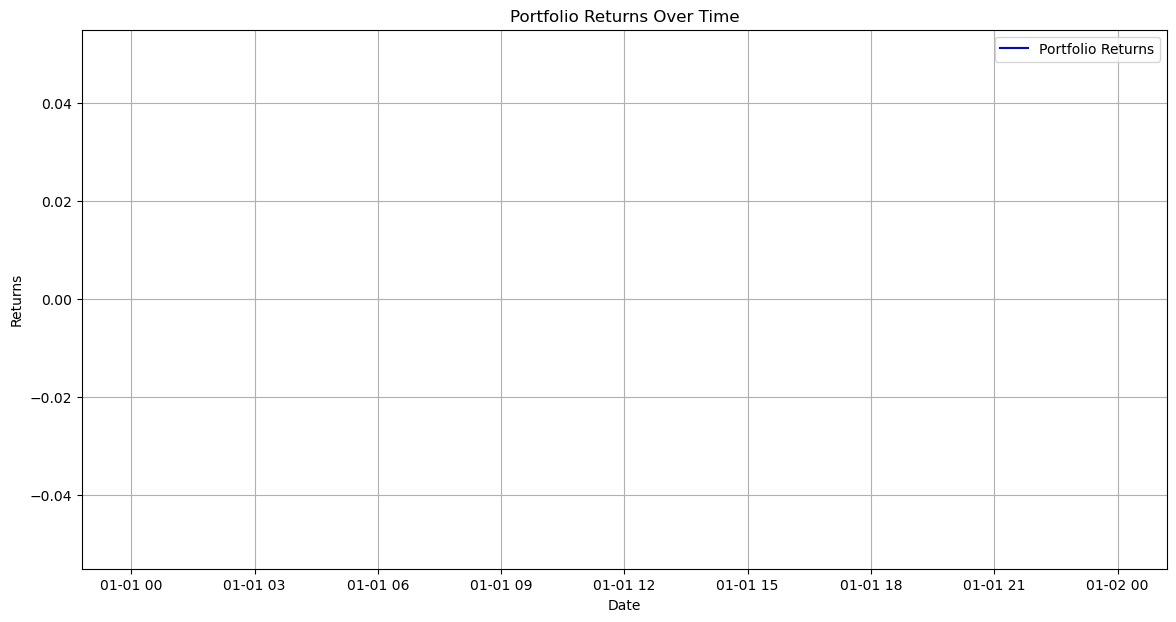

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_portfolio_value(portfolio, stock_data, date):
    """
    Calculate the portfolio value based on the current stock data at a specific date.
    """
    portfolio_value = 0.0
    for position_type in portfolio:
        if position_type not in ['buy', 'short']:
            continue
        
        for ticker, cash in portfolio[position_type].items():
            if ticker in stock_data and date in stock_data[ticker].index:
                price = stock_data[ticker].loc[date, 'Adj Close']
                if position_type == 'buy':
                    portfolio_value += cash / price
                elif position_type == 'short':
                    portfolio_value -= cash / price
    
    return portfolio_value

def calculate_portfolio_returns(stock_data, portfolio):
    """
    Calculate the daily returns of the portfolio.
    """
    dates = pd.date_range(start=start_date, end=end_date)
    portfolio_values = []
    
    for date in dates:
        # Filter stock data up to the current date
        current_stock_data = {ticker: stock_data[ticker].loc[:date] for ticker in stock_data}
        
        # Calculate portfolio value for the current date
        portfolio_value = calculate_portfolio_value(portfolio, current_stock_data, date)
        portfolio_values.append(portfolio_value)
    
    portfolio_values = np.array(portfolio_values)
    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]
    
    return dates[1:], returns

# Example usage
# Assume `top_100_tickers` and `dataset_train` have been defined earlier
# and `portfolio` contains buy and short positions

# Prepare stock data for the entire period
stock_data = {}
for ticker in top_100_tickers:
    stock_data[ticker] = load_stock_data(ticker, start_date, end_date)

# Construct portfolio based on decisions
cash = 2_000_000
portfolio = construct_portfolio(decisions, top_100_tickers, cash)

# Calculate portfolio returns
dates, returns = calculate_portfolio_returns(stock_data, portfolio)

# Plot portfolio returns
plt.figure(figsize=(14, 7))
plt.plot(dates, returns, label='Portfolio Returns', color='blue')
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()
